# Naural Networks

## Załadowanie i przygotowanie danych

In [25]:
import pandas as pd
import numpy as np
from datetime import datetime
import keras
import tensorflow
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

komentarz

In [115]:
chess = pd.read_csv("Data/games.csv")
chess = chess.loc[:4999, :]
chess.drop(columns=['created_at', 'last_move_at', 'victory_status', 'white_id', 'black_id', 'moves', 'opening_eco', 'opening_name', 'id'], inplace=True)
chess.head()

,rated,turns,winner,increment_code,white_rating,black_rating,opening_ply
0,False,13,white,15+2,1500,1191,5
1,True,16,black,5+10,1322,1261,4
2,True,61,white,5+10,1496,1500,3
3,True,61,white,20+0,1439,1454,3
4,True,95,white,30+3,1523,1469,5


In [116]:
chess.loc[:, 'rated'] = chess.loc[:, 'rated']*1

Przedstawienie na wykresie liczby wygranych białych, czarnych oraz remisów

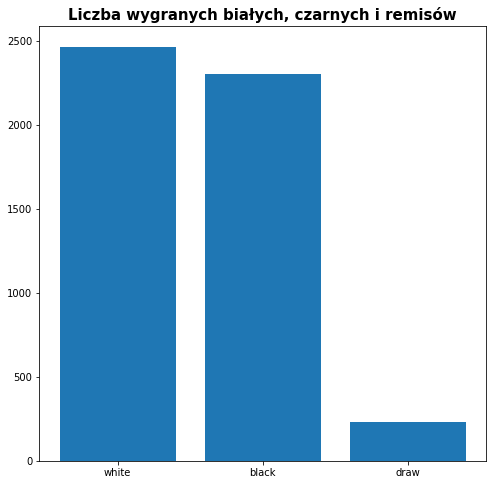

In [117]:
labels = chess.loc[:, "winner"].value_counts().index
values = chess.loc[:, "winner"].value_counts().values
plt.figure(figsize=(8, 8))
plt.bar(labels, values, align="center")
plt.title("Liczba wygranych białych, czarnych i remisów", fontdict={"fontweight": "bold", "size": 15})
plt.show()

Zakodowanie wartości kategorycznych

In [118]:
temp = pd.get_dummies(chess.loc[:, ['increment_code', 'winner']])
chess.drop(columns=['increment_code', 'winner'], inplace=True)

In [119]:
chess = pd.concat([chess, temp], axis=1)
chess.replace({np.nan, 0})

,rated,turns,white_rating,black_rating,opening_ply,increment_code_0+15,increment_code_0+25,increment_code_1+10,increment_code_1+12,increment_code_1+30,...,increment_code_9+20,increment_code_9+3,increment_code_9+5,increment_code_9+9,increment_code_90+0,increment_code_90+120,increment_code_90+30,winner_black,winner_draw,winner_white
0,0,13,1500,1191,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,16,1322,1261,4,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,61,1496,1500,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,61,1439,1454,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,95,1523,1469,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1,57,2220,2157,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4996,0,45,2157,1380,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4997,0,109,2157,1569,12,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4998,0,45,2157,2000,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [120]:
chess.loc[:, ['rated', 'turns', 'white_rating', 'black_rating', 'opening_ply']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   rated         5000 non-null   int64
 1   turns         5000 non-null   int64
 2   white_rating  5000 non-null   int64
 3   black_rating  5000 non-null   int64
 4   opening_ply   5000 non-null   int64
dtypes: int64(5)
memory usage: 195.4 KB


## Tworzenie modelu

Artykuł o tworzeniu modelu: https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

In [121]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

## Próba przewidzenie czy wygra biały, czarny czy spotkanie zakończy się remisem

Podział na zmienne objąśniające i objaśnianą

In [187]:
X = chess.drop(columns=['winner_black',	'winner_draw', 'winner_white'])
y = chess.iloc[:, -3:]

Podział na zbiór uczący i testowy w stosunku 80/20

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Tworzenie początkowego modelu z jedną warstwą wejściową, jedną ukrytą, oraz jedną wyjściową. Tworzony model będzie typu Sekwencyjnego, czyli do modelu dodajemy kolejne warstwy neuronowe, z wybranymi przez nasa parametrami.

In [189]:
model = Sequential()
model.add(Dense(units=16, input_dim=214, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=3, activation='sigmoid'))

Optymalizacja modelu do uczenia przy uzyciu adaptującego optymalizera Adam

In [190]:
opt = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Fitowanie modelu

In [191]:
y_train = y_train.values
X_train = X_train.values
batch100 = model.fit(X_train, y_train, epochs=100, batch_size=100)
batch200 = model.fit(X_train, y_train, epochs=100, batch_size=200)
batch1000 = model.fit(X_train, y_train, epochs=100, batch_size=2000)

Epoch 1/100
40/40 [==============================] - 0s 2ms/step - loss: 10.2542 - accuracy: 0.4905
Epoch 2/100
40/40 [==============================] - 0s 2ms/step - loss: 1.7903 - accuracy: 0.5527
Epoch 3/100
40/40 [==============================] - 0s 2ms/step - loss: 1.1894 - accuracy: 0.5795
Epoch 4/100
40/40 [==============================] - 0s 2ms/step - loss: 0.9920 - accuracy: 0.5975
Epoch 5/100
40/40 [==============================] - 0s 2ms/step - loss: 0.9168 - accuracy: 0.5885
Epoch 6/100
40/40 [==============================] - 0s 2ms/step - loss: 0.8664 - accuracy: 0.5853
Epoch 7/100
40/40 [==============================] - 0s 2ms/step - loss: 0.8243 - accuracy: 0.5943
Epoch 8/100
40/40 [==============================] - 0s 2ms/step - loss: 0.8393 - accuracy: 0.5915
Epoch 9/100
40/40 [==============================] - 0s 2ms/step - loss: 0.8167 - accuracy: 0.6105
Epoch 10/100
40/40 [==============================] - 0s 2ms/step - loss: 0.8122 - accuracy: 0.5982
Epoch 11

Przedstawienie accuracy dla kazdego ze 100 epchów na wykresie liniowym

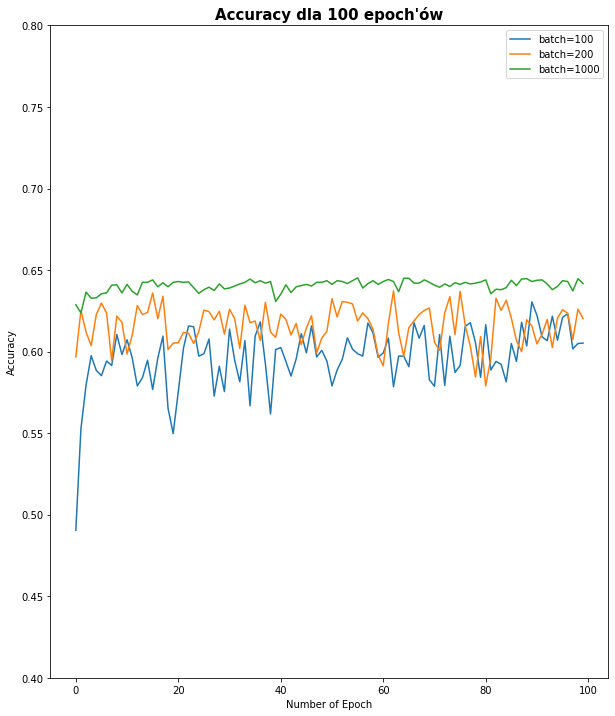

In [192]:
plt.figure(figsize=(10, 12))
plt.title("Accuracy dla 100 epoch'ów", fontdict={"fontweight": "bold", "size": 15})
plt.ylabel("Accuracy")
plt.xlabel("Number of Epoch")
plt.ylim(0.4, 0.8)
plt.plot(batch100.history['accuracy'], label="batch=100")
plt.plot(batch200.history['accuracy'], label="batch=200")
plt.plot(batch1000.history['accuracy'], label="batch=1000")
plt.legend()

Artykuł o optymalizacji: https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e

Artykuł o funkcjach aktywacyjnych: https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/

## Próba przewidzenie czy wygra biały
